In [28]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter

connection = sq.connect("./measurements.db")
connection.row_factory = sq.Row

In [13]:
def serversSupportingQUIC():
    sql = """
    SELECT DISTINCT(measurement.ip) FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def quicServersSupporting(protocol):
    sql = """
    SELECT DISTINCT(measurement.ip) FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = '{protocol}' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """.format(protocol = protocol)
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

In [18]:
quicServers = serversSupportingQUIC()
udpServers = quicServersSupporting("udp")
tcpServers = quicServersSupporting("tcp")
tlsServers = quicServersSupporting("tls")
httpsServers = quicServersSupporting("https")

In [19]:
print(len(udpServers))
print(len(tcpServers))
print(len(tlsServers))
print(len(httpsServers))

343
338
653
409


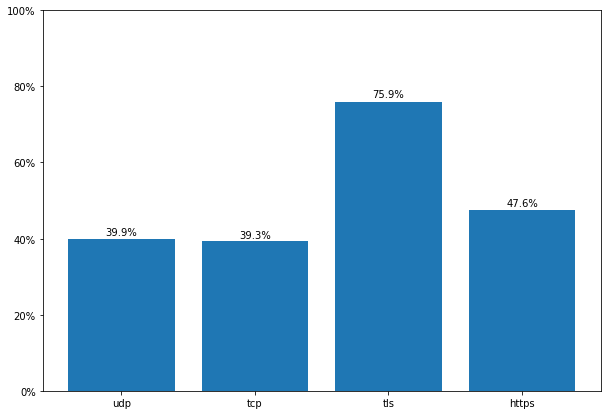

In [35]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)

rects = plt.bar(
    [
        "udp",
        "tcp",
        "tls",
        "https"
    ], 
    [
        len(udpServers)/len(quicServers) * 100, 
        len(tcpServers)/len(quicServers) * 100,
        len(tlsServers)/len(quicServers) * 100,
        len(httpsServers)/len(quicServers) * 100
    ])

formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            '%.1f' % height + "%", ha='center', va='bottom')

plt.ylim([0, 100])
plt.show()